torchio_version = 0.18.3

In [1]:
seed = 3
#!python -m pip install --upgrade pip
#!pip install --quiet --upgrade niwidgets
#!pip install --quiet --upgrade torchio
!pip install --quiet niwidgets
!pip install --quiet torchio

import random; random.seed(seed)
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import *
torch.manual_seed(seed)

import torchio
from torchio import AFFINE, DATA, PATH, TYPE, STEM

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from IPython import display

Traceback (most recent call last):
  File "C:\Users\user\Anaconda3\envs\bdy\Scripts\pip-script.py", line 6, in <module>
    from pip._internal.cli.main import main
  File "C:\Users\user\Anaconda3\envs\bdy\lib\site-packages\pip\_internal\cli\main.py", line 10, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "C:\Users\user\Anaconda3\envs\bdy\lib\site-packages\pip\_internal\cli\autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "C:\Users\user\Anaconda3\envs\bdy\lib\site-packages\pip\_internal\cli\main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "C:\Users\user\Anaconda3\envs\bdy\lib\site-packages\pip\_internal\cli\cmdoptions.py", line 24, in <module>
    from pip._internal.cli.progress_bars import BAR_TYPES
  File "C:\Users\user\Anaconda3\envs\bdy\lib\site-packages\pip\_internal\cli\progress_bars.py", line 12, in <module>
    from pip._internal.utils.logging

In [2]:
# 현재 PC의 사용가능한 GPU 사용 갯수 확인
print('TorchIO version:', torchio.__version__)
torch.cuda.device_count()

TorchIO version: 0.18.40


1

In [3]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
import pandas as pd
root = 'Y:/neuro/IXI/IXIDB_age/IXIDB2.csv'
df = pd.read_csv(root)

In [5]:
# 1 - male , 2 - female => 0 -male, 1 - female
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
df['sex'] = lb.fit_transform(df['sex'].values)
dataset_dir_name = 'Y:/neuro/IXI/IXIDB_age'
dataset_dir = Path(dataset_dir_name)

In [6]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.1086,random_state=333)

In [7]:
images_dir = dataset_dir
#csv_image_dir = images_dir / df['f'][0]

image_path = []
for i in df_train.index:
  image_path=np.array(image_path)
  image_path=np.append(image_path,[images_dir / df_train['fn'][i]])

image_paths_train = []
for i in image_path:
    image_paths_train=np.array(image_paths_train)
    image_paths_train=np.append(image_paths_train, [i / 'nifti'/ '3D_T1_reg_PD.nii.gz'])
#image_paths_train

In [8]:
images_dir = dataset_dir
#csv_image_dir = images_dir / df['f'][0]

image_path = []
for i in df_test.index:
  image_path=np.array(image_path)
  image_path=np.append(image_path,[images_dir / df_test['fn'][i]])

image_paths_test = []
for i in image_path:
    image_paths_test=np.array(image_paths_test)
    image_paths_test=np.append(image_paths_test, [i / 'nifti'/ '3D_T1_reg_PD.nii.gz'])
#image_paths_test

In [9]:
train_target_age = df_train.iloc[:,1]
train_target_age = torch.tensor(train_target_age.values).float()

test_target_age = df_test['age']
test_target_age = torch.tensor(test_target_age.values).float()

In [10]:
train_target_age = train_target_age.tolist()
#train_target_sex = train_target_sex.tolist()
test_target_age = test_target_age.tolist()
#test_target_sex = test_target_sex.tolist()

In [11]:
#원래 이미지 비트 float32인데 이걸 uint8로 바꾸자...ㅎ이거 많이들 하는듯 검색하니까 바로 나옴ㅋㅋㅋ
MRI = 'mri'
AGE = 'age'

subjects_train = []
for (k, i) in zip(image_paths_train, train_target_age):
    subject_dict = {
        MRI: torchio.ScalarImage(k),
        AGE: i,
    }
    subject = torchio.Subject(subject_dict)
    subjects_train.append(subject)
dataset_train = torchio.SubjectsDataset(subjects_train)
print('Dataset size:', len(dataset_train), 'subjects')

Dataset size: 410 subjects


In [12]:
MRI = 'mri'
AGE = 'age'

subjects_test = []
for (k, i) in zip(image_paths_test, test_target_age):
    subject_dict = {
        MRI: torchio.ScalarImage(k),
        AGE: i,
    }
    subject = torchio.Subject(subject_dict)
    subjects_test.append(subject)
dataset_test = torchio.SubjectsDataset(subjects_test)
print('Dataset size:', len(dataset_test), 'subjects')

Dataset size: 50 subjects


In [13]:
from torchio.transforms import (
    RandomFlip,
    RandomAffine,
    RandomElasticDeformation,
    RandomNoise,
    RandomMotion,
    RandomBiasField,
    RescaleIntensity,
    Resample,
    ToCanonical,
    ZNormalization,
    CropOrPad,
    HistogramStandardization,
    OneOf,
    Compose,
)

training_transform = Compose([
    #RescaleIntensity((0,1)),
    #RandomMotion(),
    #HistogramStandardization({MRI: landmarks}),
    #RandomBiasField(),
    #ZNormalization(masking_method=lambda x: x > x.mean()),
    ToCanonical(),
    RandomNoise((0,0.01),(0.01,0.05)),
    Resample((1,1,1)),
    CropOrPad((192,192,160),'constant'),
    RandomFlip(axes=(0,)),
    #RandomFlip(axes=(1,)),
    RandomAffine(    scales=(0.9,1.1),    degrees=20,    isotropic=True, translation=(-3,3,-10,10,-10,10)),
    #RandomElasticDeformation(),
    RescaleIntensity((0,1)),  # so that there are no negative values for RandomMotion
    #처음부터 다 넣었는데 val loss 막 올라감 ㅎㄷㄷ
])

validation_transform = Compose([
    #HistogramStandardization({MRI: landmarks}),
    #ZNormalization(masking_method=lambda x: x > x.mean()),
    ToCanonical(),
    Resample((1,1,1)),
    CropOrPad((192,192,160),'constant'),
    RescaleIntensity((0, 1)),
])

training_subjects = subjects_train
validation_subjects = subjects_test

training_set = torchio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = torchio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 410 subjects
Validation set: 50 subjects


In [14]:
sample = training_set[6]
img = sample[MRI][DATA]

In [15]:
sample['mri']

ScalarImage(shape: (1, 192, 192, 160); spacing: (1.00, 1.00, 1.00); orientation: RAS+; memory: 22.5 MiB; dtype: torch.FloatTensor)

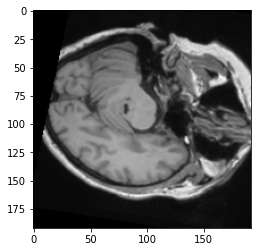

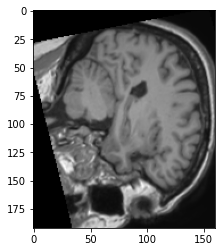

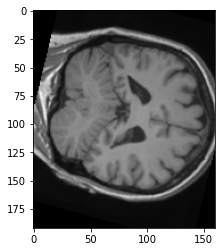

In [16]:
plt.imshow(img[0,:,:,60],'gray')
plt.show()
plt.imshow(img[0,70,:,:],'gray')
plt.show()
plt.imshow(img[0,:,70,:],'gray')
plt.show()

In [17]:
training_batch_size = 4
validation_batch_size = 4

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=0,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=0,
)

In [18]:
class Residual(nn.Module):
  
  def __init__(self,input_channels, num_channels, use_1x1conv=False, strides=1, **kwargs):
    super(Residual, self).__init__(**kwargs)
    self.conv1 = nn.Conv3d(input_channels, num_channels,kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv3d(num_channels, num_channels, kernel_size=3, padding=1)
    if use_1x1conv:
      self.conv3 = nn.Conv3d(input_channels, num_channels, kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    self.bn1 = nn.BatchNorm3d(num_channels)
    self.bn2 = nn.BatchNorm3d(num_channels)
    self.relu = nn.LeakyReLU(inplace=True)
    #self.maxpool=nn.MaxPool3d((2,2,2),stride=2)
  
  def forward(self, X):
    
    Y = self.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    Y += X
    Y =self.relu(Y)
    return Y

b1 = nn.Sequential(nn.Conv3d(1, 64, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm3d(64),
                    nn.LeakyReLU(),
                    nn.MaxPool3d(kernel_size=3, stride=2, padding=1))

def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
  blk = []
  for i in range(num_residuals):
    if i == 0 and not first_block:
      blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
    else:
      blk.append(Residual(num_channels, num_channels))
  return blk

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
b2=nn.Sequential(*resnet_block(64,64,1,first_block=True))
b3=nn.Sequential(*resnet_block(64,128,1))
b4=nn.Sequential(*resnet_block(128,256,1))
b5=nn.Sequential(*resnet_block(256,512,1))

model=nn.Sequential(b1,b2,b3,b4,b5,nn.AdaptiveMaxPool3d((1,1,1)),Flatten(),nn.Linear(512, 1))

In [19]:
#Definition of hyperparameters
num_epochs = 100

#Parameter initialization
#def init_weights(m):
#    if type(m) == nn.Linear or type(m) == nn.Conv3d:
#        torch.nn.init.kaiming_normal_(m.weight)
#model.apply(init_weights)

error = torch.nn.L1Loss()

# Optimizer
learning_rate = 3e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=1,factor=0.9)

#parameter initialization, optimizer, learning 조절, 3d resnet parameter 훨씬 많다, 일단 training set에 대해 perfect하게 만들고 시작하자.

In [23]:
model.load_state_dict(torch.load('again_again_210521_T1_reg_PD_wholeimage.pth'))

<All keys matched successfully>

epoch_train :  1
train loss:  0.14121136156100672
outputs :  tensor([[0.6467],
        [0.5667]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6087],
        [0.6969]], device='cuda:0')
valid_epoch: 1  valid_loss: 0.07124144297379714 


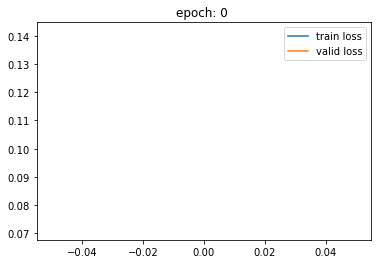

train loss:  0.14121136156100672
valid loss:  0.07124144297379714
epoch_train :  2
train loss:  0.12058808965590394
outputs :  tensor([[0.5384],
        [0.2903]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7302],
        [0.2070]], device='cuda:0')
valid_epoch: 2  valid_loss: 0.1616540138538067 


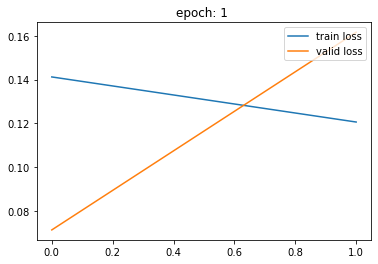

train loss:  0.12058808965590394
valid loss:  0.1616540138538067
epoch_train :  3
train loss:  0.12170401823173449
outputs :  tensor([[0.4881],
        [0.5194]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5566],
        [0.6319]], device='cuda:0')
valid_epoch: 3  valid_loss: 0.06994726107670711 


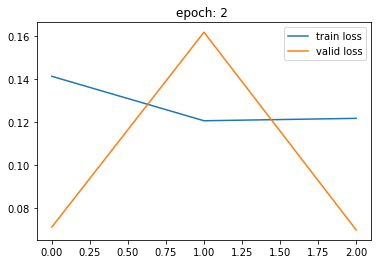

train loss:  0.12170401823173449
valid loss:  0.06994726107670711
epoch_train :  4
train loss:  0.09191423249476165
outputs :  tensor([[0.4192],
        [0.8804]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2253],
        [0.7499]], device='cuda:0')
valid_epoch: 4  valid_loss: 0.13449553342965934 


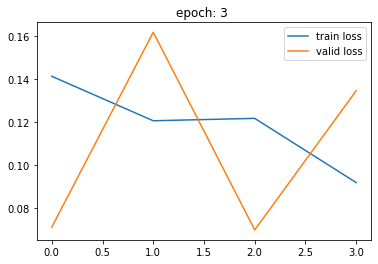

train loss:  0.09191423249476165
valid loss:  0.13449553342965934
epoch_train :  5
train loss:  0.12032110714217992
outputs :  tensor([[0.4765],
        [0.4255]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3647],
        [0.4190]], device='cuda:0')
valid_epoch: 5  valid_loss: 0.10474963371570294 


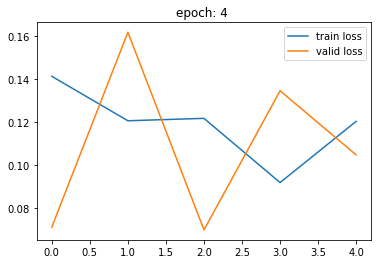

train loss:  0.12032110714217992
valid loss:  0.10474963371570294
epoch_train :  6
train loss:  0.11318586405041148
outputs :  tensor([[0.5707],
        [0.6647]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2157],
        [0.2957]], device='cuda:0')
valid_epoch: 6  valid_loss: 0.266374422953679 


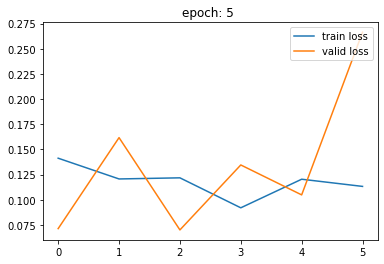

train loss:  0.11318586405041148
valid loss:  0.266374422953679
epoch_train :  7
train loss:  0.10573229743439017
outputs :  tensor([[0.3736],
        [0.5562]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5558],
        [0.6812]], device='cuda:0')
valid_epoch: 7  valid_loss: 0.210099458694458 


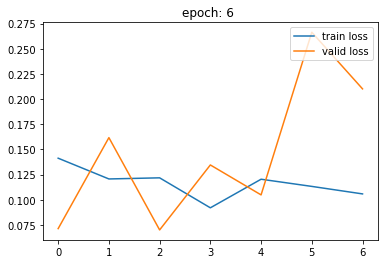

train loss:  0.10573229743439017
valid loss:  0.210099458694458
epoch_train :  8
train loss:  0.10253741440263767
outputs :  tensor([[0.4606],
        [0.5294]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6046],
        [0.5989]], device='cuda:0')
valid_epoch: 8  valid_loss: 0.0775462480691763 


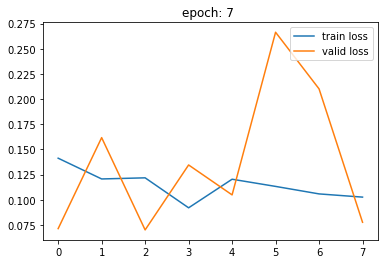

train loss:  0.10253741440263767
valid loss:  0.0775462480691763
epoch_train :  9
train loss:  0.10291613421393829
outputs :  tensor([[0.5051],
        [0.6633]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2851],
        [0.4120]], device='cuda:0')
valid_epoch: 9  valid_loss: 0.07157709048344539 


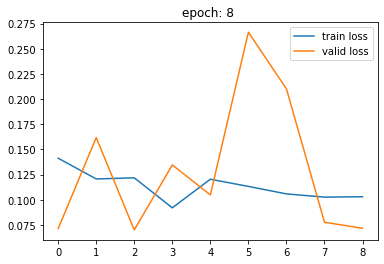

train loss:  0.10291613421393829
valid loss:  0.07157709048344539
epoch_train :  10
train loss:  0.10228812578812387
outputs :  tensor([[0.5452],
        [0.3430]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6695],
        [0.2485]], device='cuda:0')
valid_epoch: 10  valid_loss: 0.08259244148547833 


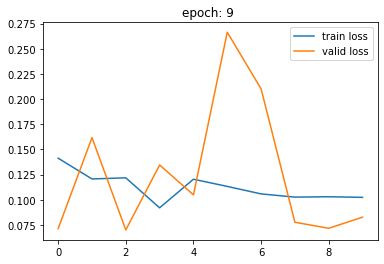

train loss:  0.10228812578812387
valid loss:  0.08259244148547833
epoch_train :  11
train loss:  0.10978020973575925
outputs :  tensor([[0.6531],
        [0.7240]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5721],
        [0.3421]], device='cuda:0')
valid_epoch: 11  valid_loss: 0.07214589302356426 


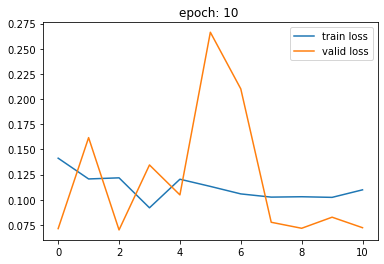

train loss:  0.10978020973575925
valid loss:  0.07214589302356426
epoch_train :  12
train loss:  0.09255500904564719
outputs :  tensor([[0.4759],
        [0.3353]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2928],
        [0.2434]], device='cuda:0')
valid_epoch: 12  valid_loss: 0.07171362179976243 


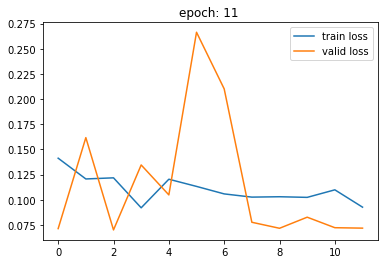

train loss:  0.09255500904564719
valid loss:  0.07171362179976243
epoch_train :  13
train loss:  0.076902250641758
outputs :  tensor([[0.4986],
        [0.5929]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6091],
        [0.6753]], device='cuda:0')
valid_epoch: 13  valid_loss: 0.09354340113126315 


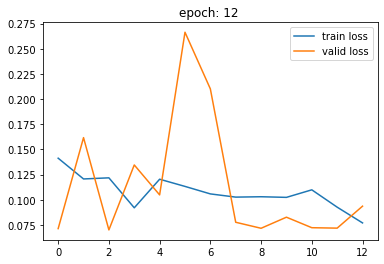

train loss:  0.076902250641758
valid loss:  0.09354340113126315
epoch_train :  14
train loss:  0.08531723207640417
outputs :  tensor([[0.7745],
        [0.7796]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7166],
        [0.7583]], device='cuda:0')
valid_epoch: 14  valid_loss: 0.09100074951465313 


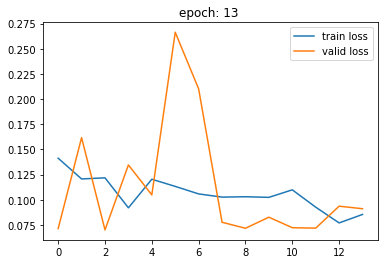

train loss:  0.08531723207640417
valid loss:  0.09100074951465313
epoch_train :  15
train loss:  0.08151004383864913
outputs :  tensor([[0.5385],
        [0.4975]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5419],
        [0.2574]], device='cuda:0')
valid_epoch: 15  valid_loss: 0.19278177848229042 


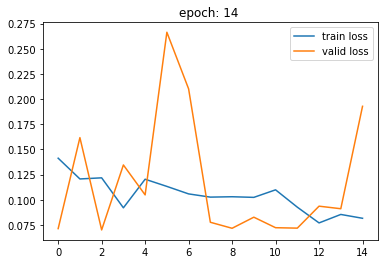

train loss:  0.08151004383864913
valid loss:  0.19278177848229042
epoch_train :  16
train loss:  0.0691979093459046
outputs :  tensor([[0.7113],
        [0.5684]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6733],
        [0.5428]], device='cuda:0')
valid_epoch: 16  valid_loss: 0.08787643909454346 


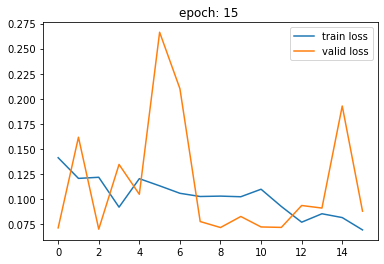

train loss:  0.0691979093459046
valid loss:  0.08787643909454346
epoch_train :  17
train loss:  0.07474833553277173
outputs :  tensor([[0.4024],
        [0.1706]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4402],
        [0.2887]], device='cuda:0')
valid_epoch: 17  valid_loss: 0.07089306299503033 


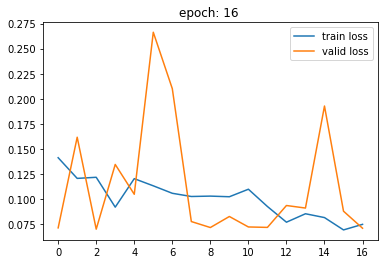

train loss:  0.07474833553277173
valid loss:  0.07089306299503033
epoch_train :  18
train loss:  0.07591716988572797
outputs :  tensor([[0.4334],
        [0.3257]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5002],
        [0.3429]], device='cuda:0')
valid_epoch: 18  valid_loss: 0.06915385448015653 


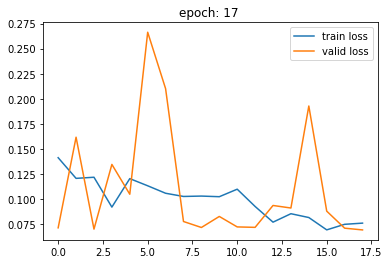

train loss:  0.07591716988572797
valid loss:  0.06915385448015653
epoch_train :  19
train loss:  0.08704037342256712
outputs :  tensor([[0.6344],
        [0.2853]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6011],
        [0.2594]], device='cuda:0')
valid_epoch: 19  valid_loss: 0.07700262619898869 


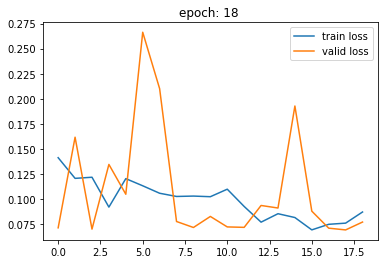

train loss:  0.08704037342256712
valid loss:  0.07700262619898869
epoch_train :  20
train loss:  0.068975693971208
outputs :  tensor([[0.3709],
        [0.3665]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4622],
        [0.4120]], device='cuda:0')
valid_epoch: 20  valid_loss: 0.05603004418886625 


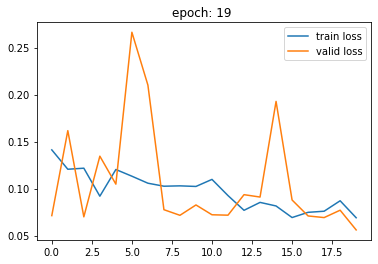

train loss:  0.068975693971208
valid loss:  0.05603004418886625
epoch_train :  21
train loss:  0.07246137359767284
outputs :  tensor([[0.4681],
        [0.8166]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3018],
        [0.7025]], device='cuda:0')
valid_epoch: 21  valid_loss: 0.09228175420027512 


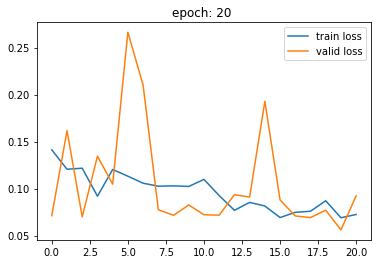

train loss:  0.07246137359767284
valid loss:  0.09228175420027512
epoch_train :  22
train loss:  0.08228444590151889
outputs :  tensor([[0.5737],
        [0.3694]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4940],
        [0.3647]], device='cuda:0')
valid_epoch: 22  valid_loss: 0.06471235018510085 


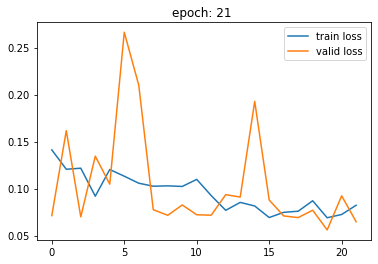

train loss:  0.08228444590151889
valid loss:  0.06471235018510085
epoch_train :  23
train loss:  0.08425693141603932
outputs :  tensor([[0.4886],
        [0.1948]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7227],
        [0.3014]], device='cuda:0')
valid_epoch: 23  valid_loss: 0.1074975637289194 


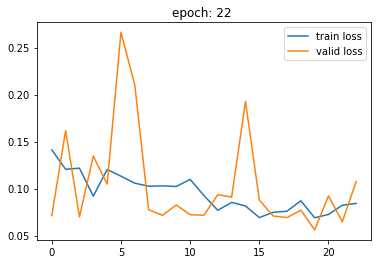

train loss:  0.08425693141603932
valid loss:  0.1074975637289194
epoch_train :  24
train loss:  0.07306490592586184
outputs :  tensor([[0.7572],
        [0.5333]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7084],
        [0.3421]], device='cuda:0')
valid_epoch: 24  valid_loss: 0.09617268122159518 


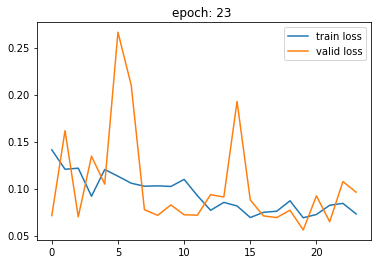

train loss:  0.07306490592586184
valid loss:  0.09617268122159518
epoch_train :  25
train loss:  0.06773814877260079
outputs :  tensor([[0.5271],
        [0.6163]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5230],
        [0.6366]], device='cuda:0')
valid_epoch: 25  valid_loss: 0.10944889141963078 


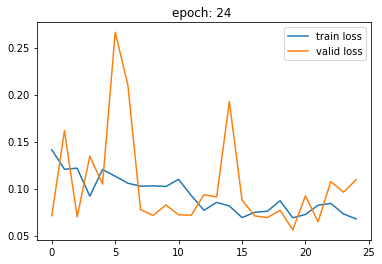

train loss:  0.06773814877260079
valid loss:  0.10944889141963078
epoch_train :  26
train loss:  0.07086406170743183
outputs :  tensor([[0.6322],
        [0.5512]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6354],
        [0.5524]], device='cuda:0')
valid_epoch: 26  valid_loss: 0.05977088212966919 


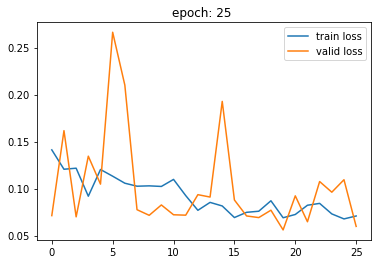

train loss:  0.07086406170743183
valid loss:  0.05977088212966919
epoch_train :  27
train loss:  0.06131277269530065
outputs :  tensor([[0.4551],
        [0.5942]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4492],
        [0.5915]], device='cuda:0')
valid_epoch: 27  valid_loss: 0.06976825457352859 


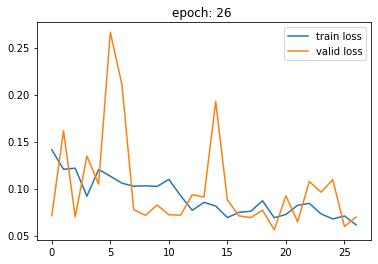

train loss:  0.06131277269530065
valid loss:  0.06976825457352859
epoch_train :  28
train loss:  0.06323459310439027
outputs :  tensor([[0.5694],
        [0.6752]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6397],
        [0.6149]], device='cuda:0')
valid_epoch: 28  valid_loss: 0.07246851004087008 


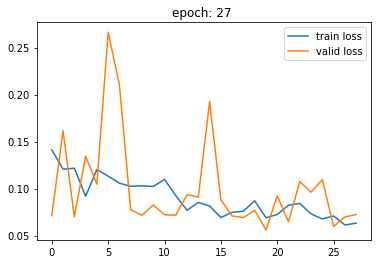

train loss:  0.06323459310439027
valid loss:  0.07246851004087008
epoch_train :  29
train loss:  0.06524034611229758
outputs :  tensor([[0.5711],
        [0.4101]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7259],
        [0.5002]], device='cuda:0')
valid_epoch: 29  valid_loss: 0.07840586625612699 


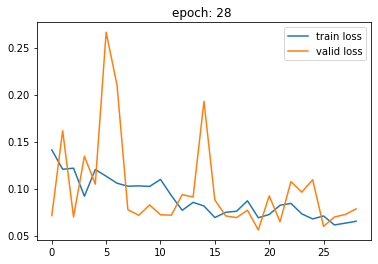

train loss:  0.06524034611229758
valid loss:  0.07840586625612699
epoch_train :  30
train loss:  0.060235625331841625
outputs :  tensor([[0.5086],
        [0.7874]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5375],
        [0.7014]], device='cuda:0')
valid_epoch: 30  valid_loss: 0.09085177458249606 


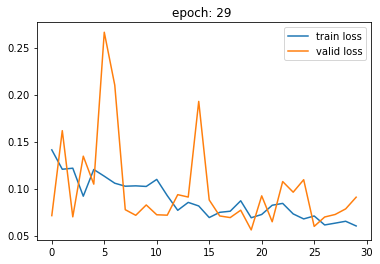

train loss:  0.060235625331841625
valid loss:  0.09085177458249606
epoch_train :  31
train loss:  0.05978024584575764
outputs :  tensor([[0.6963],
        [0.5621]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6007],
        [0.5696]], device='cuda:0')
valid_epoch: 31  valid_loss: 0.0996413781092717 


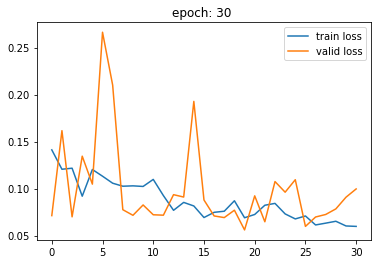

train loss:  0.05978024584575764
valid loss:  0.0996413781092717
epoch_train :  32
train loss:  0.06334650169298486
outputs :  tensor([[0.4743],
        [0.2757]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4174],
        [0.2900]], device='cuda:0')
valid_epoch: 32  valid_loss: 0.059652406435746416 


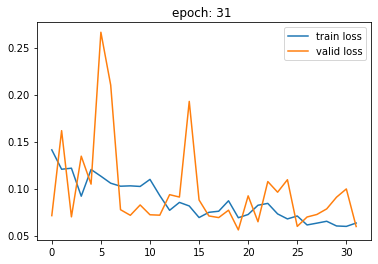

train loss:  0.06334650169298486
valid loss:  0.059652406435746416
epoch_train :  33
train loss:  0.060405897862702895
outputs :  tensor([[0.5730],
        [0.3598]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4297],
        [0.2558]], device='cuda:0')
valid_epoch: 33  valid_loss: 0.0701905947465163 


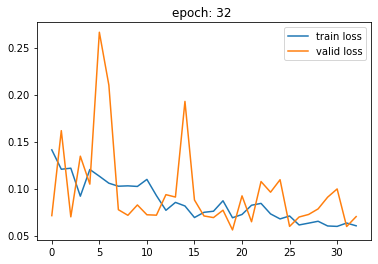

train loss:  0.060405897862702895
valid loss:  0.0701905947465163
epoch_train :  34
train loss:  0.06224289218198906
outputs :  tensor([[0.4050],
        [0.3227]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5872],
        [0.4316]], device='cuda:0')
valid_epoch: 34  valid_loss: 0.07882287869086632 


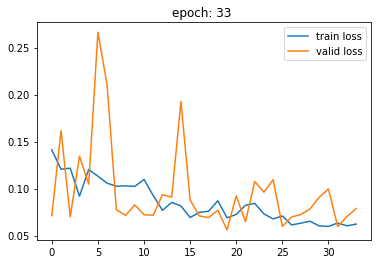

train loss:  0.06224289218198906
valid loss:  0.07882287869086632
epoch_train :  35
train loss:  0.06124676547004181
outputs :  tensor([[0.5249],
        [0.5512]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4120],
        [0.5354]], device='cuda:0')
valid_epoch: 35  valid_loss: 0.06821046425746037 


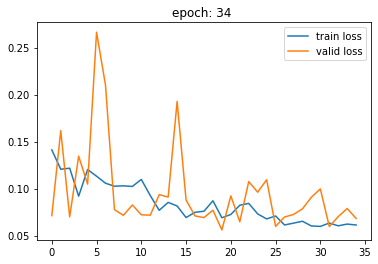

train loss:  0.06124676547004181
valid loss:  0.06821046425746037
epoch_train :  36
train loss:  0.06574628885509898
outputs :  tensor([[0.6118],
        [0.3149]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4855],
        [0.2418]], device='cuda:0')
valid_epoch: 36  valid_loss: 0.07230804516718937 


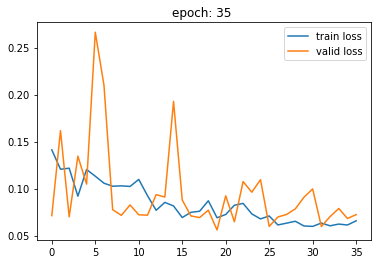

train loss:  0.06574628885509898
valid loss:  0.07230804516718937
epoch_train :  37
train loss:  0.050272751780389584
outputs :  tensor([[0.4469],
        [0.2782]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4195],
        [0.3070]], device='cuda:0')
valid_epoch: 37  valid_loss: 0.06219974847940298 


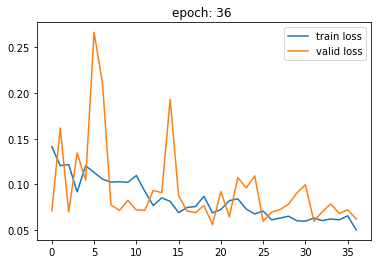

train loss:  0.050272751780389584
valid loss:  0.06219974847940298
epoch_train :  38
train loss:  0.05514752286151775
outputs :  tensor([[0.3413],
        [0.7093]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4392],
        [0.6087]], device='cuda:0')
valid_epoch: 38  valid_loss: 0.06312367549309364 


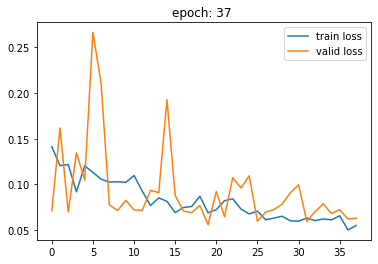

train loss:  0.05514752286151775
valid loss:  0.06312367549309364
epoch_train :  39
train loss:  0.05777437710067601
outputs :  tensor([[0.6362],
        [0.3851]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6008],
        [0.3622]], device='cuda:0')
valid_epoch: 39  valid_loss: 0.06454167916224553 


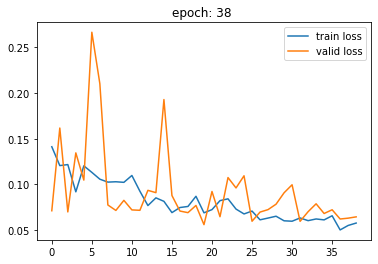

train loss:  0.05777437710067601
valid loss:  0.06454167916224553
epoch_train :  40
train loss:  0.05631282954540068
outputs :  tensor([[0.3066],
        [0.8267]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4001],
        [0.8620]], device='cuda:0')
valid_epoch: 40  valid_loss: 0.06094945394075834 


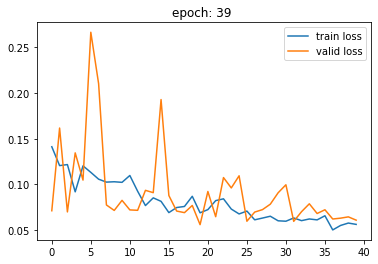

train loss:  0.05631282954540068
valid loss:  0.06094945394075834
epoch_train :  41
train loss:  0.05466276002161711
outputs :  tensor([[0.4226],
        [0.5220]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4195],
        [0.5289]], device='cuda:0')
valid_epoch: 41  valid_loss: 0.058058706613687366 


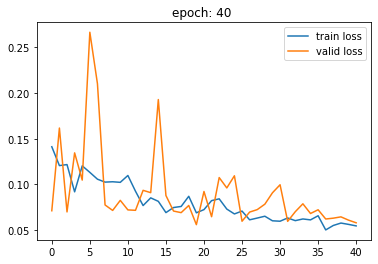

train loss:  0.05466276002161711
valid loss:  0.058058706613687366
epoch_train :  42
train loss:  0.05376264423999971
outputs :  tensor([[0.4600],
        [0.6110]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5002],
        [0.6397]], device='cuda:0')
valid_epoch: 42  valid_loss: 0.05801898699540358 


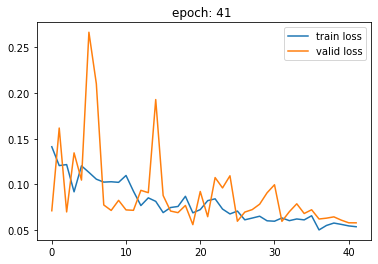

train loss:  0.05376264423999971
valid loss:  0.05801898699540358
epoch_train :  43
train loss:  0.05399954434737418
outputs :  tensor([[0.3885],
        [0.5845]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3606],
        [0.6339]], device='cuda:0')
valid_epoch: 43  valid_loss: 0.060735885913555436 


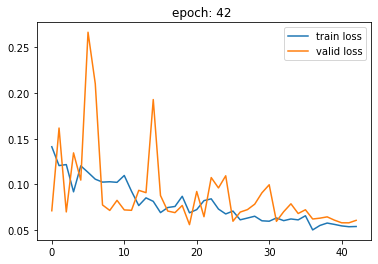

train loss:  0.05399954434737418
valid loss:  0.060735885913555436
epoch_train :  44
train loss:  0.05281870573469736
outputs :  tensor([[0.5358],
        [0.6436]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6046],
        [0.6087]], device='cuda:0')
valid_epoch: 44  valid_loss: 0.06005726410792424 


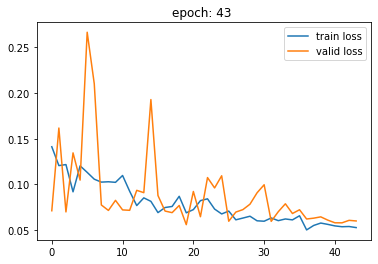

train loss:  0.05281870573469736
valid loss:  0.06005726410792424
epoch_train :  45
train loss:  0.055472878576482386
outputs :  tensor([[0.6384],
        [0.5313]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6753],
        [0.6777]], device='cuda:0')
valid_epoch: 45  valid_loss: 0.0625154421879695 


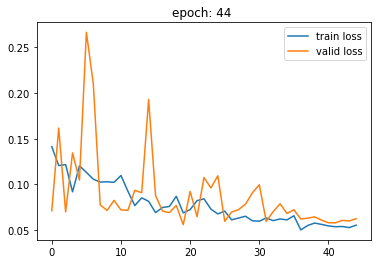

train loss:  0.055472878576482386
valid loss:  0.0625154421879695
epoch_train :  46
train loss:  0.05563077648866524
outputs :  tensor([[0.6438],
        [0.5412]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7084],
        [0.5449]], device='cuda:0')
valid_epoch: 46  valid_loss: 0.060060386474315934 


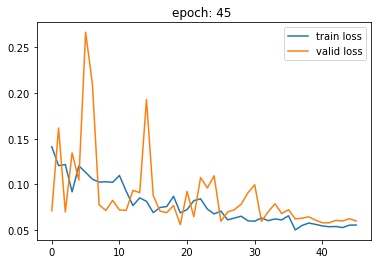

train loss:  0.05563077648866524
valid loss:  0.060060386474315934
epoch_train :  47
train loss:  0.0474528386754897
outputs :  tensor([[0.5883],
        [0.5614]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6011],
        [0.5969]], device='cuda:0')
valid_epoch: 47  valid_loss: 0.058772463064927324 


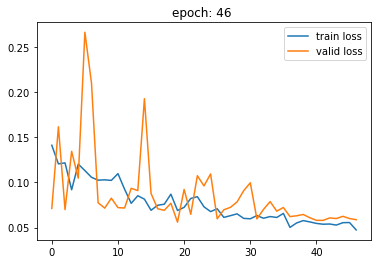

train loss:  0.0474528386754897
valid loss:  0.058772463064927324
epoch_train :  48
train loss:  0.04851270879356606
outputs :  tensor([[0.5488],
        [0.5412]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5707],
        [0.4562]], device='cuda:0')
valid_epoch: 48  valid_loss: 0.062320402035346396 


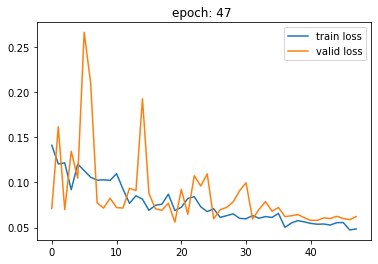

train loss:  0.04851270879356606
valid loss:  0.062320402035346396
epoch_train :  49
train loss:  0.049729226862342615
outputs :  tensor([[0.5552],
        [0.5731]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6200],
        [0.6134]], device='cuda:0')
valid_epoch: 49  valid_loss: 0.052669451786921576 


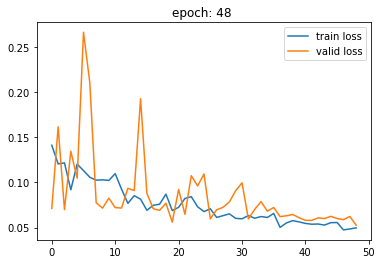

train loss:  0.049729226862342615
valid loss:  0.052669451786921576
epoch_train :  50
train loss:  0.04946598497409265
outputs :  tensor([[0.4504],
        [0.7178]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4123],
        [0.6653]], device='cuda:0')
valid_epoch: 50  valid_loss: 0.06592242992841281 


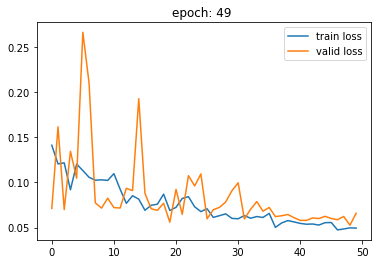

train loss:  0.04946598497409265
valid loss:  0.06592242992841281
epoch_train :  51
train loss:  0.05167064851927526
outputs :  tensor([[0.5394],
        [0.4274]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4855],
        [0.3369]], device='cuda:0')
valid_epoch: 51  valid_loss: 0.060286870369544394 


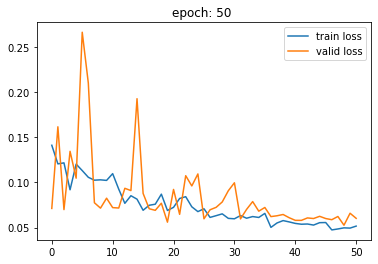

train loss:  0.05167064851927526
valid loss:  0.060286870369544394
epoch_train :  52
train loss:  0.04712196461205344
outputs :  tensor([[0.5127],
        [0.4914]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5166],
        [0.4808]], device='cuda:0')
valid_epoch: 52  valid_loss: 0.05711110280110286 


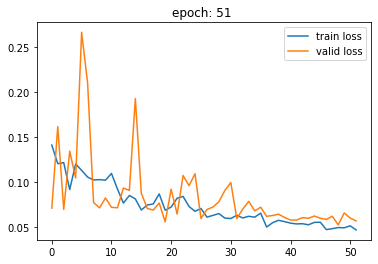

train loss:  0.04712196461205344
valid loss:  0.05711110280110286
epoch_train :  53
train loss:  0.04672197230811258
outputs :  tensor([[0.4289],
        [0.3591]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3904],
        [0.2928]], device='cuda:0')
valid_epoch: 53  valid_loss: 0.05542391080122728 


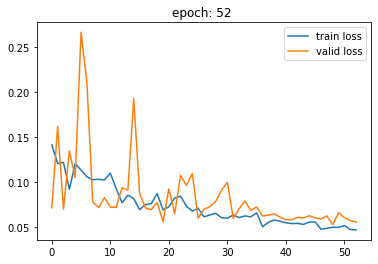

train loss:  0.04672197230811258
valid loss:  0.05542391080122728
epoch_train :  54
train loss:  0.051298604428189475
outputs :  tensor([[0.4549],
        [0.3839]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3692],
        [0.3437]], device='cuda:0')
valid_epoch: 54  valid_loss: 0.052224888251377985 


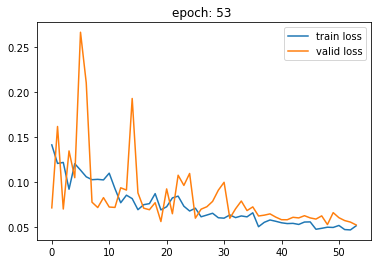

train loss:  0.051298604428189475
valid loss:  0.052224888251377985
epoch_train :  55
train loss:  0.05091575511450906
outputs :  tensor([[0.3868],
        [0.4490]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3647],
        [0.4279]], device='cuda:0')
valid_epoch: 55  valid_loss: 0.05582950665400578 


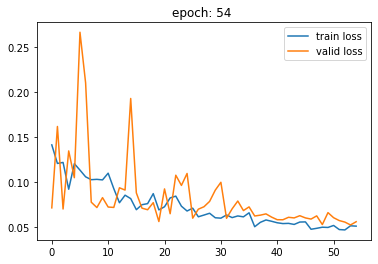

train loss:  0.05091575511450906
valid loss:  0.05582950665400578
epoch_train :  56
train loss:  0.04749944835033232
outputs :  tensor([[0.5945],
        [0.4228]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6458],
        [0.5419]], device='cuda:0')
valid_epoch: 56  valid_loss: 0.0644738169816824 


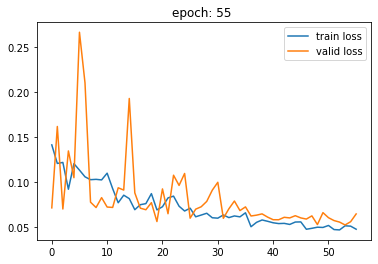

train loss:  0.04749944835033232
valid loss:  0.0644738169816824
epoch_train :  57
train loss:  0.047240109119600464
outputs :  tensor([[0.2655],
        [0.5696]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3581],
        [0.6243]], device='cuda:0')
valid_epoch: 57  valid_loss: 0.059702616471510664 


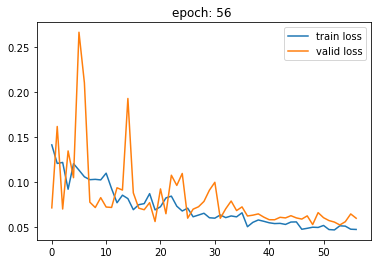

train loss:  0.047240109119600464
valid loss:  0.059702616471510664
epoch_train :  58
train loss:  0.05052240149488727
outputs :  tensor([[0.5039],
        [0.3891]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5969],
        [0.5230]], device='cuda:0')
valid_epoch: 58  valid_loss: 0.05727966015155499 


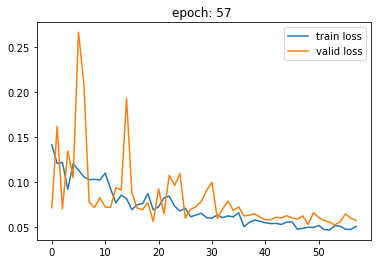

train loss:  0.05052240149488727
valid loss:  0.05727966015155499
epoch_train :  59
train loss:  0.049105204424811796
outputs :  tensor([[0.6874],
        [0.5988]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7941],
        [0.5804]], device='cuda:0')
valid_epoch: 59  valid_loss: 0.0709366981799786 


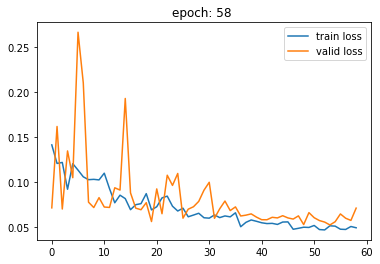

train loss:  0.049105204424811796
valid loss:  0.0709366981799786
epoch_train :  60
train loss:  0.04617887330286711
outputs :  tensor([[0.7431],
        [0.2951]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6848],
        [0.2701]], device='cuda:0')
valid_epoch: 60  valid_loss: 0.05986635501568134 


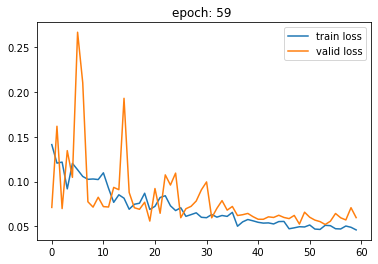

train loss:  0.04617887330286711
valid loss:  0.05986635501568134
epoch_train :  61
train loss:  0.045663018828456844
outputs :  tensor([[0.2380],
        [0.6983]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2241],
        [0.6686]], device='cuda:0')
valid_epoch: 61  valid_loss: 0.06184612787686861 


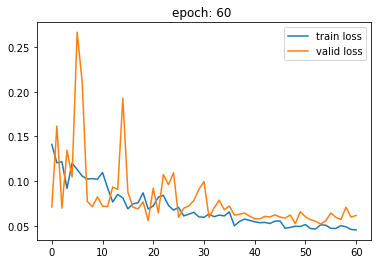

train loss:  0.045663018828456844
valid loss:  0.06184612787686861
epoch_train :  62
train loss:  0.048410744342989136
outputs :  tensor([[0.4559],
        [0.3050]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3648],
        [0.2701]], device='cuda:0')
valid_epoch: 62  valid_loss: 0.06526002975610587 


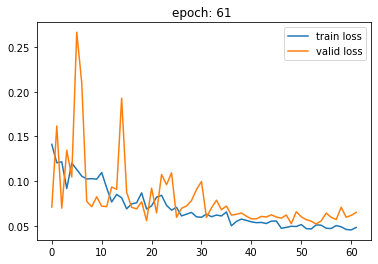

train loss:  0.048410744342989136
valid loss:  0.06526002975610587
epoch_train :  63
train loss:  0.04808649507541101
outputs :  tensor([[0.7058],
        [0.4500]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7233],
        [0.3795]], device='cuda:0')
valid_epoch: 63  valid_loss: 0.05943206640390249 


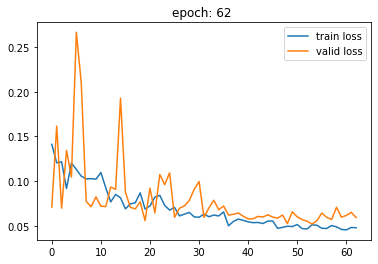

train loss:  0.04808649507541101
valid loss:  0.05943206640390249
epoch_train :  64
train loss:  0.04500326138098263
outputs :  tensor([[0.6124],
        [0.5111]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6706],
        [0.5188]], device='cuda:0')
valid_epoch: 64  valid_loss: 0.05772682336660532 


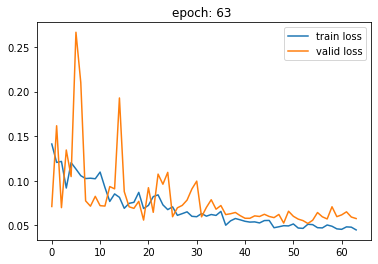

train loss:  0.04500326138098263
valid loss:  0.05772682336660532
epoch_train :  65
train loss:  0.049211048385471974
outputs :  tensor([[0.2672],
        [0.6076]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2418],
        [0.6010]], device='cuda:0')
valid_epoch: 65  valid_loss: 0.059428893602811374 


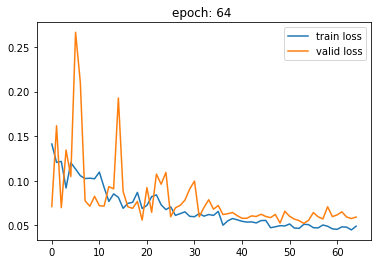

train loss:  0.049211048385471974
valid loss:  0.059428893602811374
epoch_train :  66
train loss:  0.043474248312052016
outputs :  tensor([[0.5570],
        [0.3975]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4855],
        [0.3314]], device='cuda:0')
valid_epoch: 66  valid_loss: 0.06412074199089637 


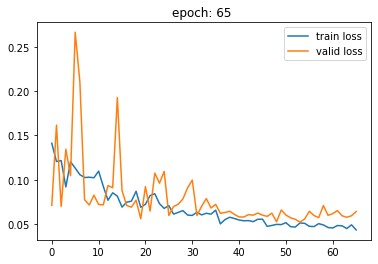

train loss:  0.043474248312052016
valid loss:  0.06412074199089637
epoch_train :  67
train loss:  0.04698652897066283
outputs :  tensor([[0.3341],
        [0.3163]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3314],
        [0.3545]], device='cuda:0')
valid_epoch: 67  valid_loss: 0.060574536140148454 


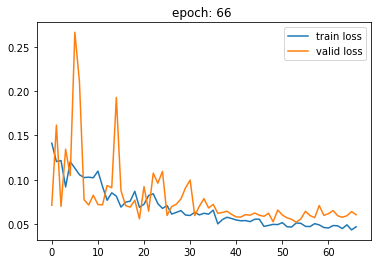

train loss:  0.04698652897066283
valid loss:  0.060574536140148454
epoch_train :  68
train loss:  0.04644072634502522
outputs :  tensor([[0.6322],
        [0.3182]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6695],
        [0.3400]], device='cuda:0')
valid_epoch: 68  valid_loss: 0.06578306509898259 


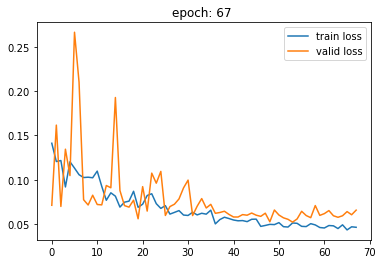

train loss:  0.04644072634502522
valid loss:  0.06578306509898259
epoch_train :  69
train loss:  0.04383704268816605
outputs :  tensor([[0.4986],
        [0.7179]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4120],
        [0.7354]], device='cuda:0')
valid_epoch: 69  valid_loss: 0.062148442635169394 


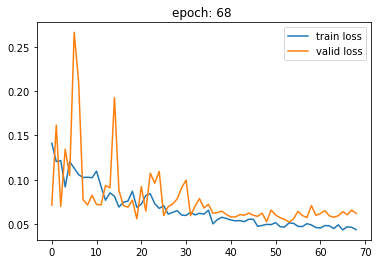

train loss:  0.04383704268816605
valid loss:  0.062148442635169394
epoch_train :  70
train loss:  0.044580899395988985
outputs :  tensor([[0.6955],
        [0.3713]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6637],
        [0.3896]], device='cuda:0')
valid_epoch: 70  valid_loss: 0.06302408988659199 


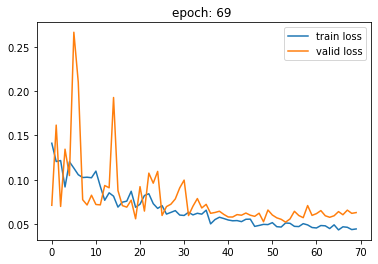

train loss:  0.044580899395988985
valid loss:  0.06302408988659199
epoch_train :  71
train loss:  0.04451435052075432
outputs :  tensor([[0.6629],
        [0.4513]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6711],
        [0.4279]], device='cuda:0')
valid_epoch: 71  valid_loss: 0.07251225068018986 


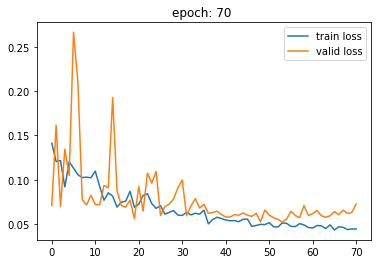

train loss:  0.04451435052075432
valid loss:  0.07251225068018986
epoch_train :  72
train loss:  0.04433727727352994
outputs :  tensor([[0.3428],
        [0.6130]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3264],
        [0.5947]], device='cuda:0')
valid_epoch: 72  valid_loss: 0.05939887578670795 


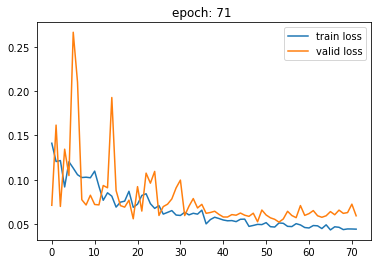

train loss:  0.04433727727352994
valid loss:  0.05939887578670795
epoch_train :  73
train loss:  0.04538620791388947
outputs :  tensor([[0.5048],
        [0.3601]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5267],
        [0.2812]], device='cuda:0')
valid_epoch: 73  valid_loss: 0.06452341721608089 


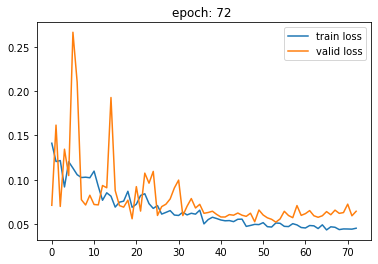

train loss:  0.04538620791388947
valid loss:  0.06452341721608089
epoch_train :  74
train loss:  0.043214705383893354
outputs :  tensor([[0.2099],
        [0.3708]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2091],
        [0.3878]], device='cuda:0')
valid_epoch: 74  valid_loss: 0.06240400901207557 


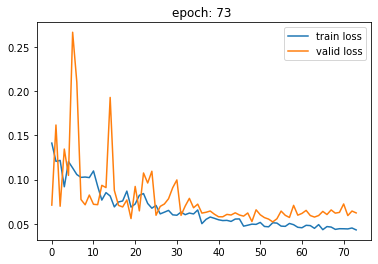

train loss:  0.043214705383893354
valid loss:  0.06240400901207557
epoch_train :  75
train loss:  0.045841832762783016
outputs :  tensor([[0.4443],
        [0.5876]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3294],
        [0.6084]], device='cuda:0')
valid_epoch: 75  valid_loss: 0.07075430338199322 


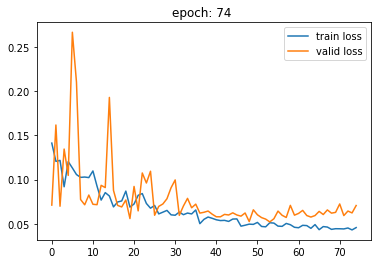

train loss:  0.045841832762783016
valid loss:  0.07075430338199322
epoch_train :  76
train loss:  0.04382171445679896
outputs :  tensor([[0.4611],
        [0.2044]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3692],
        [0.2093]], device='cuda:0')
valid_epoch: 76  valid_loss: 0.06557525579745953 


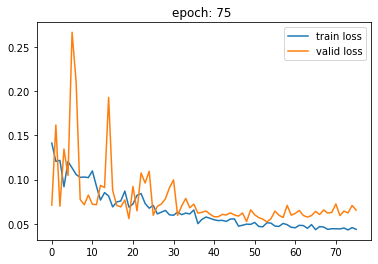

train loss:  0.04382171445679896
valid loss:  0.06557525579745953
epoch_train :  77
train loss:  0.04516510361606635
outputs :  tensor([[0.3919],
        [0.1874]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3352],
        [0.2856]], device='cuda:0')
valid_epoch: 77  valid_loss: 0.05694436568480272 


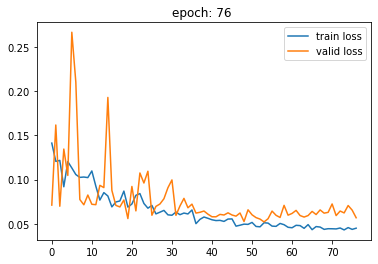

train loss:  0.04516510361606635
valid loss:  0.05694436568480272
epoch_train :  78
train loss:  0.044225447386213874
outputs :  tensor([[0.5660],
        [0.4574]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5721],
        [0.5668]], device='cuda:0')
valid_epoch: 78  valid_loss: 0.0609542910869305 


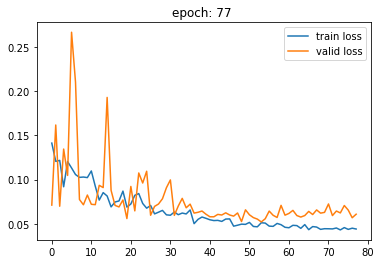

train loss:  0.044225447386213874
valid loss:  0.0609542910869305
epoch_train :  79
train loss:  0.04623439011064548
outputs :  tensor([[0.6169],
        [0.3855]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6933],
        [0.2928]], device='cuda:0')
valid_epoch: 79  valid_loss: 0.06019905897287222 


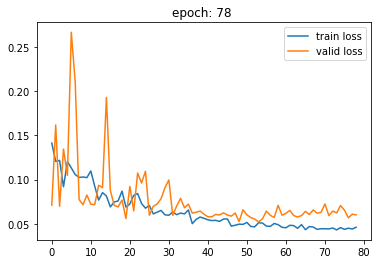

train loss:  0.04623439011064548
valid loss:  0.06019905897287222
epoch_train :  80
train loss:  0.04439874760155539
outputs :  tensor([[0.6020],
        [0.4712]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5129],
        [0.3795]], device='cuda:0')
valid_epoch: 80  valid_loss: 0.06503816751333383 


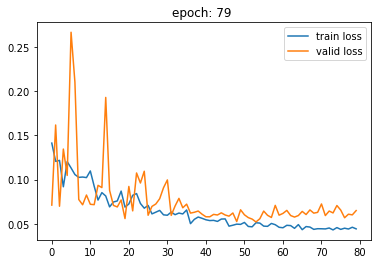

train loss:  0.04439874760155539
valid loss:  0.06503816751333383
epoch_train :  81
train loss:  0.046329414960250115
outputs :  tensor([[0.6442],
        [0.6337]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6280],
        [0.6585]], device='cuda:0')
valid_epoch: 81  valid_loss: 0.06605738401412964 


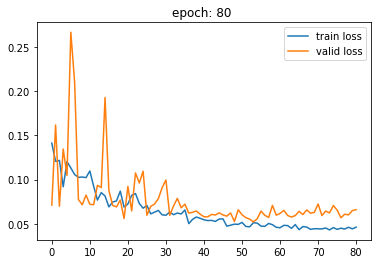

train loss:  0.046329414960250115
valid loss:  0.06605738401412964
epoch_train :  82
train loss:  0.04380440480500749
outputs :  tensor([[0.3847],
        [0.4786]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3429],
        [0.4299]], device='cuda:0')
valid_epoch: 82  valid_loss: 0.05977782836327186 


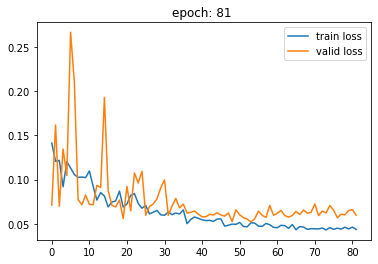

train loss:  0.04380440480500749
valid loss:  0.05977782836327186
epoch_train :  83
train loss:  0.042613964636348985
outputs :  tensor([[0.3969],
        [0.4229]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3400],
        [0.3795]], device='cuda:0')
valid_epoch: 83  valid_loss: 0.0610425380560068 


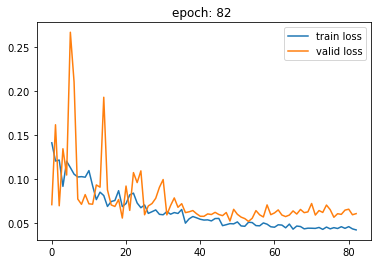

train loss:  0.042613964636348985
valid loss:  0.0610425380560068
epoch_train :  84
train loss:  0.041027768144329776
outputs :  tensor([[0.3239],
        [0.2850]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2861],
        [0.2887]], device='cuda:0')
valid_epoch: 84  valid_loss: 0.05885581786815937 


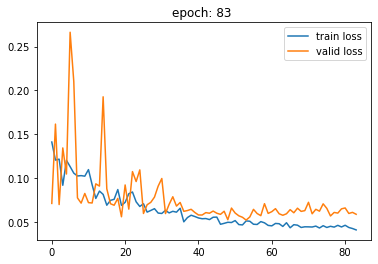

train loss:  0.041027768144329776
valid loss:  0.05885581786815937
epoch_train :  85
train loss:  0.04465301754405197
outputs :  tensor([[0.6702],
        [0.2726]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7209],
        [0.3196]], device='cuda:0')
valid_epoch: 85  valid_loss: 0.0666568737763625 


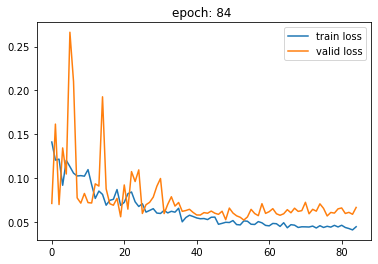

train loss:  0.04465301754405197
valid loss:  0.0666568737763625
epoch_train :  86
train loss:  0.042202097698322776
outputs :  tensor([[0.4383],
        [0.2929]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3795],
        [0.3437]], device='cuda:0')
valid_epoch: 86  valid_loss: 0.06773836796100323 


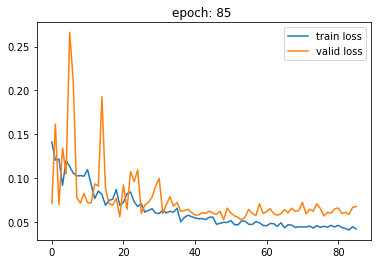

train loss:  0.042202097698322776
valid loss:  0.06773836796100323
epoch_train :  87
train loss:  0.04023972298335103
outputs :  tensor([[0.4341],
        [0.4440]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4488],
        [0.4133]], device='cuda:0')
valid_epoch: 87  valid_loss: 0.06383510736318734 


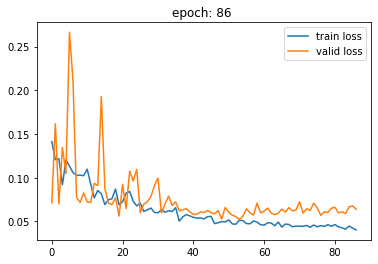

train loss:  0.04023972298335103
valid loss:  0.06383510736318734
epoch_train :  88
train loss:  0.04267414796699598
outputs :  tensor([[0.6310],
        [0.7284]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5967],
        [0.7563]], device='cuda:0')
valid_epoch: 88  valid_loss: 0.063246671970074 


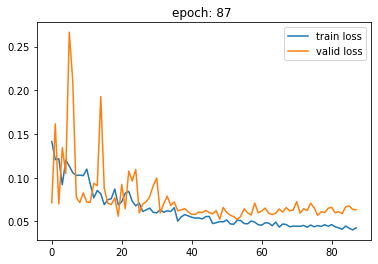

train loss:  0.04267414796699598
valid loss:  0.063246671970074
epoch_train :  89
train loss:  0.042658393822827385
outputs :  tensor([[0.2748],
        [0.3089]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2693],
        [0.2541]], device='cuda:0')
valid_epoch: 89  valid_loss: 0.06663341705615704 


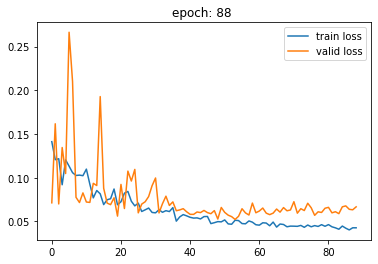

train loss:  0.042658393822827385
valid loss:  0.06663341705615704
epoch_train :  90
train loss:  0.04232420504671856
outputs :  tensor([[0.4892],
        [0.4630]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.4122],
        [0.4643]], device='cuda:0')
valid_epoch: 90  valid_loss: 0.06514120101928711 


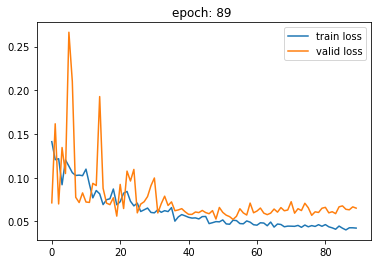

train loss:  0.04232420504671856
valid loss:  0.06514120101928711
epoch_train :  91
train loss:  0.042573132561248485
outputs :  tensor([[0.4792],
        [0.5871]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5878],
        [0.6084]], device='cuda:0')
valid_epoch: 91  valid_loss: 0.06130461050913884 


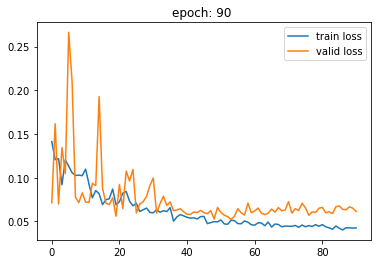

train loss:  0.042573132561248485
valid loss:  0.06130461050913884
epoch_train :  92
train loss:  0.0408097424553436
outputs :  tensor([[0.7251],
        [0.3497]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.7121],
        [0.4222]], device='cuda:0')
valid_epoch: 92  valid_loss: 0.06310421686906081 


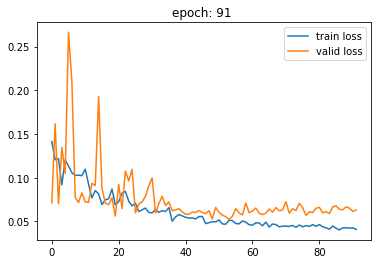

train loss:  0.0408097424553436
valid loss:  0.06310421686906081
epoch_train :  93
train loss:  0.04375325823293149
outputs :  tensor([[0.2532],
        [0.3382]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2304],
        [0.5253]], device='cuda:0')
valid_epoch: 93  valid_loss: 0.061543707664196305 


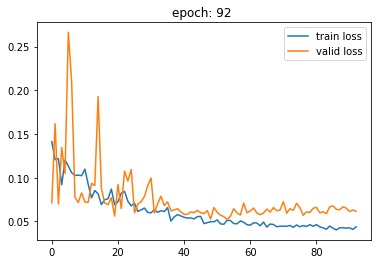

train loss:  0.04375325823293149
valid loss:  0.061543707664196305
epoch_train :  94
train loss:  0.04290490011567051
outputs :  tensor([[0.3263],
        [0.5702]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2856],
        [0.6010]], device='cuda:0')
valid_epoch: 94  valid_loss: 0.06093337902655968 


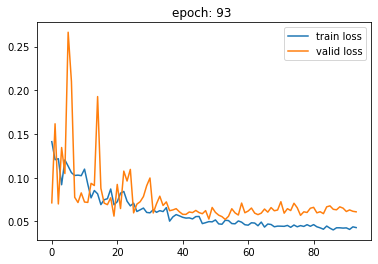

train loss:  0.04290490011567051
valid loss:  0.06093337902655968
epoch_train :  95
train loss:  0.04459768591575252
outputs :  tensor([[0.3134],
        [0.4925]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.2739],
        [0.4637]], device='cuda:0')
valid_epoch: 95  valid_loss: 0.06424146432142991 


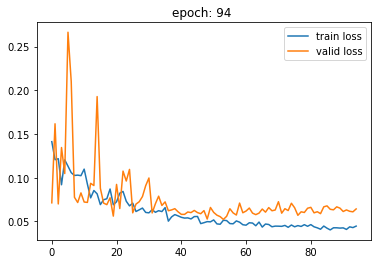

train loss:  0.04459768591575252
valid loss:  0.06424146432142991
epoch_train :  96
train loss:  0.040226260435233994
outputs :  tensor([[0.6136],
        [0.2677]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.6410],
        [0.2120]], device='cuda:0')
valid_epoch: 96  valid_loss: 0.06299735949589656 


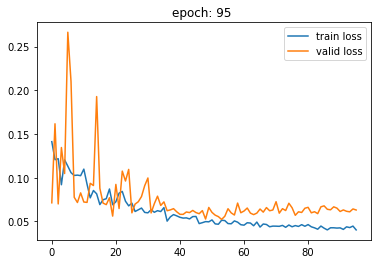

train loss:  0.040226260435233994
valid loss:  0.06299735949589656
epoch_train :  97
train loss:  0.04247961229491003
outputs :  tensor([[0.6318],
        [0.3207]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5857],
        [0.2335]], device='cuda:0')
valid_epoch: 97  valid_loss: 0.0625839875294612 


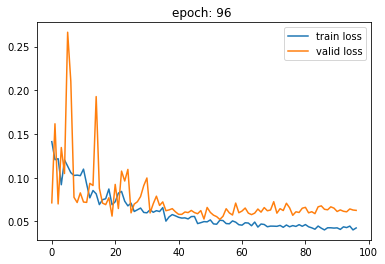

train loss:  0.04247961229491003
valid loss:  0.0625839875294612
epoch_train :  98
train loss:  0.04038410742306015
outputs :  tensor([[0.5570],
        [0.1643]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.5554],
        [0.2091]], device='cuda:0')
valid_epoch: 98  valid_loss: 0.06005697066967304 


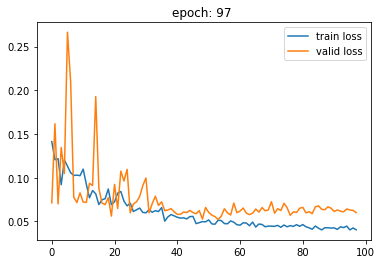

train loss:  0.04038410742306015
valid loss:  0.06005697066967304
epoch_train :  99
train loss:  0.042196945079322
outputs :  tensor([[0.3758],
        [0.7452]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3089],
        [0.7583]], device='cuda:0')
valid_epoch: 99  valid_loss: 0.059244279678051286 


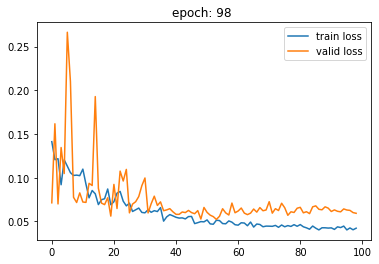

train loss:  0.042196945079322
valid loss:  0.059244279678051286
epoch_train :  100
train loss:  0.04309164436118117
outputs :  tensor([[0.3756],
        [0.3380]], device='cuda:0', grad_fn=<SliceBackward>)
label :  tensor([[0.3648],
        [0.4112]], device='cuda:0')
valid_epoch: 100  valid_loss: 0.061824945303109974 


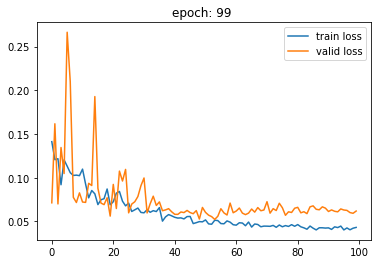

train loss:  0.04309164436118117
valid loss:  0.061824945303109974


In [25]:
# CNN model training
#원본 이미지에 대해서 resample를 해도 데이터 보존이 2p0나 1p5에 비해 워낙 잘 되어있어서 그만큼 데이터 complexity가 높다.

## 모델 파라미터 저장하는거 제목 꼭 바꿔라!!!!!! ##

count = 0
loss_valid = np.array([])
iteration_list = []
loss_train = np.array([])

for epoch in range(num_epochs):
    count += 1
    i=0
    l_epoch=0
    
    for batch in training_loader:
        model.to(device).train()
        inputs_train = batch['mri'][DATA].to(device)
        target_train = (batch['age']/100.).float().to(device)
        i=i+1
        optimizer.zero_grad()
        outputs = model(inputs_train)
        target_train= target_train.reshape(-1,1)
        loss = error(outputs, target_train).to(device)
        l_epoch+=loss
        loss.backward()
        optimizer.step()
        
    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    print('epoch_train : ',count)
    print('train loss: ',loss_train[-1])
    print('outputs : ',outputs[:5])
    print('label : ',target_train[:5])
    torch.save(model.state_dict(), f'again_again_210524_T1_reg_PD_wholeimage.pth')
        
    i=0
    l_epoch=0
    with torch.no_grad():
        for batch in validation_loader:
          model.to(device).eval()
          inputs_test = batch['mri'][DATA].to(device)
          target_test = (batch['age']/100.).float().to(device)
          i=i+1
          outputs = model(inputs_test)
          target_test= target_test.reshape(-1,1)
          loss = error(outputs, target_test).to(device)
          l_epoch+=loss
        loss_valid = np.append(loss_valid,l_epoch.cpu().detach().numpy()/i)
        scheduler.step(loss_valid[-1])
    
    print('valid_epoch: {}  valid_loss: {} '.format(count, loss_valid[-1]))
    plt.plot(loss_train,label='train loss')
    plt.plot(loss_valid,label='valid loss')

    plt.legend(loc='upper right')
    plt.title('epoch: %d '%(epoch))
    plt.pause(.0001)

    print('train loss: ',loss_train[-1])
    print('valid loss: ',loss_valid[-1])


In [20]:
model.load_state_dict(torch.load('again_again_210524_T1_reg_PD_wholeimage.pth'))

<All keys matched successfully>

In [21]:
with torch.no_grad():
    y_hat=np.array([])
    y=np.array([])
    for batch in validation_loader:
          model.to(device).eval()
          inputs_test = batch['mri'][torchio.DATA].to(device)
          target_test = (batch['age']/100).float().to(device)
          output = model(inputs_test)
          y_hat = np.append(y_hat,output.cpu().detach().numpy())
          y = np.append(y,target_test.cpu().detach().numpy())

print(y_hat)
print(y)

[0.75462765 0.57599092 0.60269928 0.35393241 0.46151683 0.26316682
 0.36904246 0.19674051 0.73725271 0.60745567 0.74030352 0.45005664
 0.80693859 0.60528702 0.6934132  0.66433847 0.57628155 0.36431175
 0.57501978 0.52360624 0.6375581  0.60048544 0.60278434 0.55800247
 0.31947622 0.35581508 0.68665564 0.75415146 0.5636729  0.41436803
 0.25067848 0.5962708  0.27981612 0.48561755 0.27247211 0.73603773
 0.78506088 0.30990484 0.50875896 0.78261703 0.44378349 0.52640104
 0.33153504 0.7111721  0.56088132 0.56437033 0.39916861 0.25499415
 0.43790862 0.47846255]
[0.62061602 0.449911   0.59222448 0.29092404 0.48678985 0.22973306
 0.50650239 0.22431211 0.69067764 0.59381247 0.68509239 0.44093087
 0.72884321 0.52498287 0.63096505 0.74026006 0.60027379 0.41511294
 0.56873375 0.48254621 0.66907603 0.58376455 0.59742641 0.61587954
 0.27822042 0.24895278 0.74636549 0.64646131 0.37210128 0.44481862
 0.31854895 0.60596853 0.36670771 0.505243   0.40035591 0.65667349
 0.69546884 0.24689938 0.54685831 0.74

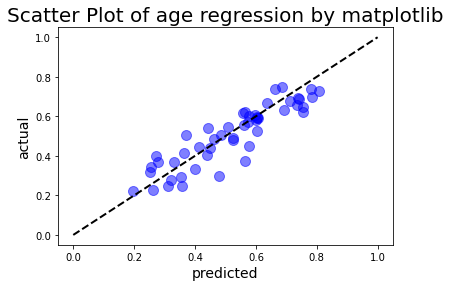

In [22]:
plt.plot(y_hat,y,linestyle='none',marker='o',markersize=10,color='blue',alpha=0.5)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
plt.title('Scatter Plot of age regression by matplotlib', fontsize=20)
plt.xlabel('predicted', fontsize=14)
plt.ylabel('actual', fontsize=14)
plt.show()

In [23]:
df = pd.DataFrame({"predicted":y_hat, "actual":y})
corr = df.corr(method = 'pearson') 
corr

,predicted,actual
predicted,1.000000,0.897929
actual,0.897929,1.000000


In [24]:
df_test['T1_predict_age'] = y_hat*100
df_test.drop('sex',axis=1, inplace=True)
df_test.drop('h',axis=1, inplace=True)
df_test.drop('w',axis=1, inplace=True)
df_test.drop('eth',axis=1, inplace=True)
df_test

,fn,age,T1_predict_age
270,IXI358-Guys-0919,62.061602,75.462765
231,IXI287-Guys-0863,44.991102,57.599092
16,IXI029-Guys-0829,59.222450,60.269928
5,IXI017-Guys-0698,29.092402,35.393241
261,IXI342-Guys-0909,48.678987,46.151683
101,IXI122-Guys-0773,22.973306,26.316682
32,IXI048-HH-1326,50.650240,36.904246
126,IXI153-Guys-0782,22.431211,19.674051
360,IXI488-Guys-1015,69.067762,73.725271
128,IXI156-Guys-0837,59.381246,60.745567


In [25]:
df_test['T1_mae'] = df_test['T1_predict_age']-df_test['age']
df_test

,fn,age,T1_predict_age,T1_mae
270,IXI358-Guys-0919,62.061602,75.462765,13.401163
231,IXI287-Guys-0863,44.991102,57.599092,12.607990
16,IXI029-Guys-0829,59.222450,60.269928,1.047478
5,IXI017-Guys-0698,29.092402,35.393241,6.300839
261,IXI342-Guys-0909,48.678987,46.151683,-2.527304
101,IXI122-Guys-0773,22.973306,26.316682,3.343376
32,IXI048-HH-1326,50.650240,36.904246,-13.745994
126,IXI153-Guys-0782,22.431211,19.674051,-2.757161
360,IXI488-Guys-1015,69.067762,73.725271,4.657509
128,IXI156-Guys-0837,59.381246,60.745567,1.364321


In [27]:
df_MRA = pd.read_csv('Z:/dyb/Final_age_prediction/MRA_result.csv')
df_MRA

,Unnamed: 0,fn,age,MRA_predict_age,MRA_mae
0,270,IXI358-Guys-0919,62.061602,59.268904,-2.792698
1,231,IXI287-Guys-0863,44.991102,64.268535,19.277433
2,16,IXI029-Guys-0829,59.222450,54.645938,-4.576513
3,5,IXI017-Guys-0698,29.092402,32.552350,3.459947
4,261,IXI342-Guys-0909,48.678987,37.714693,-10.964294
5,101,IXI122-Guys-0773,22.973306,25.341985,2.368679
6,32,IXI048-HH-1326,50.650240,28.158435,-22.491804
7,126,IXI153-Guys-0782,22.431211,30.677232,8.246021
8,360,IXI488-Guys-1015,69.067762,49.414951,-19.652811
9,128,IXI156-Guys-0837,59.381246,56.260556,-3.120690


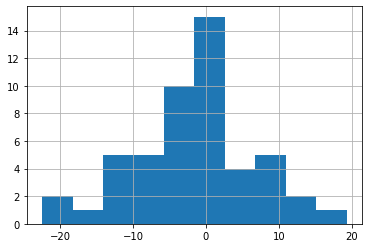

In [28]:
T1_mae = df_test['T1_mae'].tolist()
MRA_mae = df_MRA['MRA_mae'].tolist()

hist = df_MRA['MRA_mae'].hist()

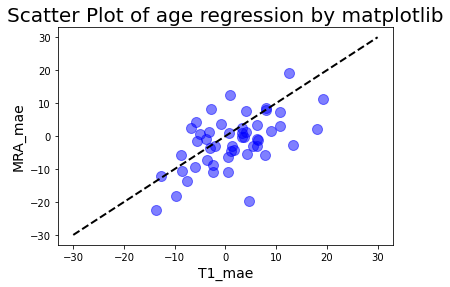

In [29]:
plt.plot(T1_mae,MRA_mae,linestyle='none',marker='o',markersize=10,color='blue',alpha=0.5)
plt.plot([-30,30],[-30,30],linestyle = '--',lw = 2,color = 'black')
plt.title('Scatter Plot of age regression by matplotlib', fontsize=20)
plt.xlabel('T1_mae', fontsize=14)
plt.ylabel('MRA_mae', fontsize=14)
plt.show()

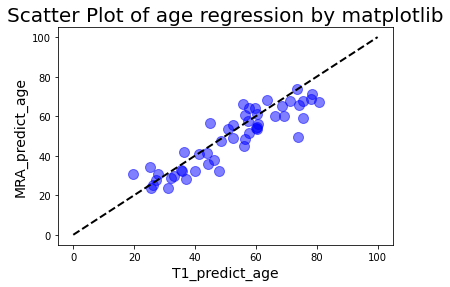

In [30]:
a = df_test['T1_predict_age'].tolist()
b = df_MRA['MRA_predict_age'].tolist()

plt.plot(a,b,linestyle='none',marker='o',markersize=10,color='blue',alpha=0.5)
plt.plot([0,100],[0,100],linestyle = '--',lw = 2,color = 'black')
plt.title('Scatter Plot of age regression by matplotlib', fontsize=20)
plt.xlabel('T1_predict_age', fontsize=14)
plt.ylabel('MRA_predict_age', fontsize=14)
plt.show()

In [31]:
c=df_MRA['age'].tolist()

In [32]:
dff = pd.DataFrame({"T1_predict_age" : a,"MRA_predict_age" : b, "Actual_age" : c})
corr_pa = dff.corr(method='pearson')
corr_pa

,T1_predict_age,MRA_predict_age,Actual_age
T1_predict_age,1.000000,0.901271,0.897929
MRA_predict_age,0.901271,1.000000,0.856670
Actual_age,0.897929,0.856670,1.000000


In [37]:
dfff = pd.DataFrame({"T1_MAE" : T1_mae,"MRA_MAE" : MRA_mae})
corr_pad = dfff.corr(method='pearson')
corr_pad

,T1_MAE,MRA_MAE
T1_MAE,1.000000,0.568427
MRA_MAE,0.568427,1.000000


In [38]:
df_MRA['MRA_mae'].mean(),df_test['T1_mae'].mean()

(-1.7802217176383253, 1.4139787981087448)

- 뇌혈관 노화도가 평균적으로 뇌 노화보다 느리다. 
- 다만 뇌혈관 노화 정도와 뇌 노화 정도는 비슷하긴 하다. IXI048,IXI045의 경우 뇌 노화, 뇌 혈관 노화 모두 늦다.
- 제일 좋은 것은 grad-cam 실현하기...근데 까다로울 듯 하다.